# Radon example from Gelman and Hill (2006)
This is a reworking of the radon example from pymc3 https://docs.pymc.io/notebooks/multilevel_modeling.html


Other implementations in: 

- tensorflow https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer - pymc3 https://docs.pymc.io/notebooks/multilevel_modeling.html 

- stan https://mc-stan.org/users/documentation/case-studies/radon.html 

- pyro https://github.com/pyro-ppl/pyro-models/blob/master/pyro_models/arm/radon.py 

- numpyro fibrosis dataset http://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html

In [7]:
import altair as alt
try:
    alt.renderers.enable('altair_saver', fmts=['png'])
except Exception:
    pass
from bayes_window import BayesWindow, BayesConditions, LMERegression, BayesRegression
from utils import load_radon
df = load_radon()

df

,county,radon,floor
0,AITKIN,2.2,1
1,AITKIN,2.2,0
2,AITKIN,2.9,0
3,AITKIN,1.0,0
4,ANOKA,3.1,0
...,...,...,...
922,WRIGHT,6.4,0
923,WRIGHT,4.5,0
924,WRIGHT,5.0,0
925,YELLOW MEDICINE,3.7,0


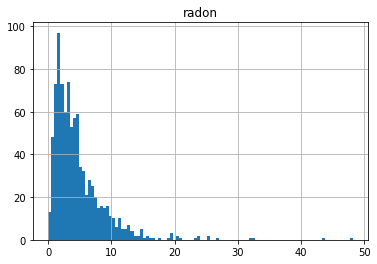

In [3]:
df.set_index(['county','floor']).hist(bins=100);

In [4]:
window=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')

## Plot data

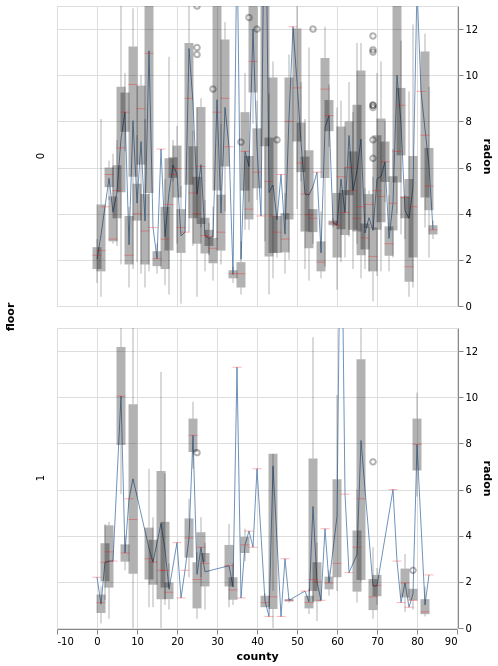

In [5]:
window.plot(x='county').facet(row='floor')

## Fit LME

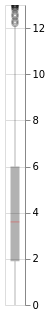

In [8]:
lme=LMERegression(window)#formula='radon ~ floor + ( 1 | county)')

window.plot()

## Fit Bayesian hierarchical with and without county-specific intercept

2021-11-30 15:37:12.522319: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW


Uneven number of entries in conditions! This will lead to nans in data (window.data["radon diff"(170, 120)


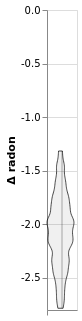

In [10]:
window1=BayesRegression(df=df.reset_index(), y='radon', treatment='floor',group='county')
window1.fit(add_group_intercept=True);
window1.plot()

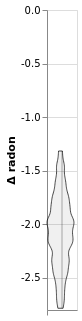

In [11]:
window1.plot(x=':O')

### Inspect intercepts (horizontal ticks)

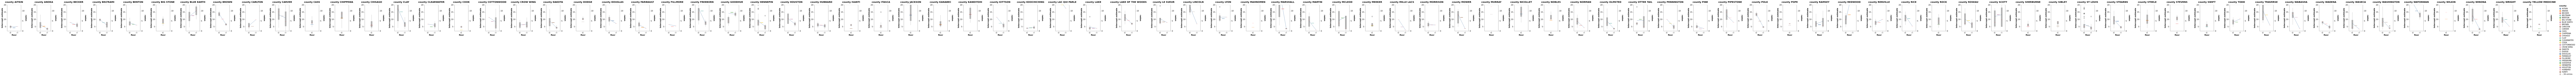

In [12]:
window1.plot_intercepts()

Uneven number of entries in conditions! This will lead to nans in data (window.data["radon diff"(170, 120)


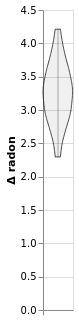

In [13]:
window2=BayesRegression(df=df.reset_index(), y='radon', treatment='floor',group='county')
window2.fit(add_group_intercept=False, add_group_slope=False, do_make_change='subtract');
window2.plot()

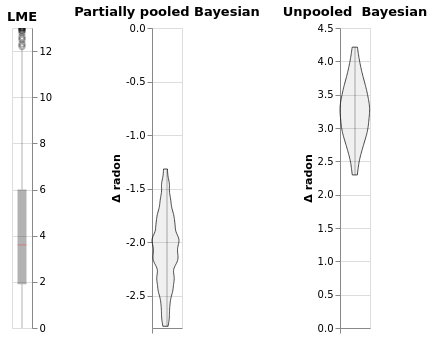

In [14]:
(window.plot().properties(title='LME')|
 window1.plot().properties(title='Partially pooled Bayesian')|
 window2.plot().properties(title='Unpooled  Bayesian'))

## Compare the two models

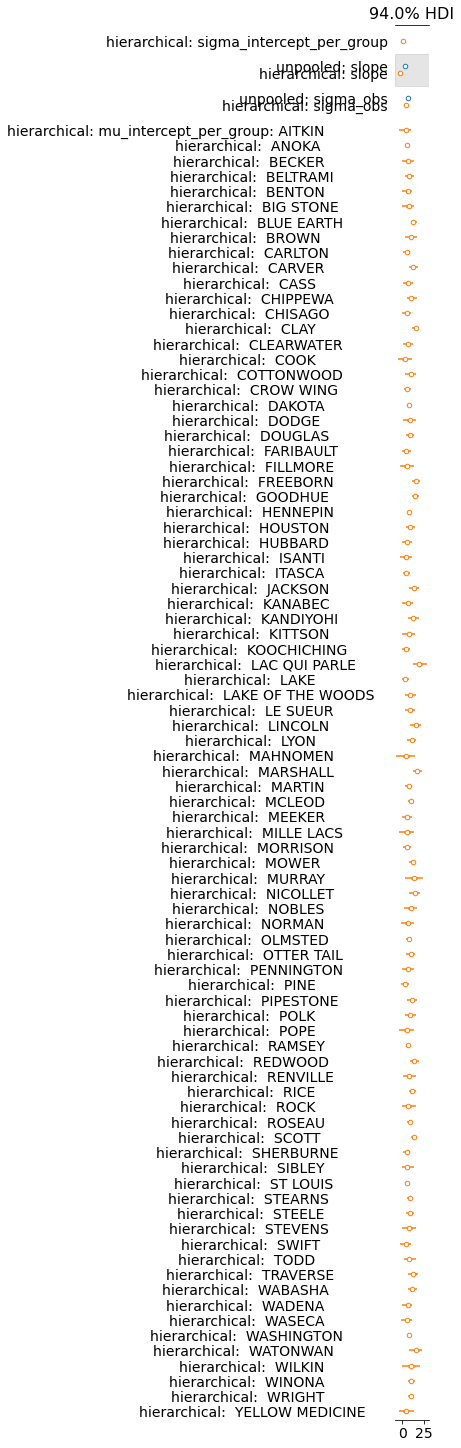

In [15]:
import arviz as az
datasets = {'unpooled' : window2.trace.posterior,
           'hierarchical': window1.trace.posterior} 

az.plot_forest(data=list(datasets.values()), model_names=list(datasets.keys()), 
               #backend='bokeh',
               #kind='ridgeplot',
               #ridgeplot_overlap=1.6,
               combined=True);



For leave-one-out, let's remove any counties that did not contain both floors. This drops about 250 rows

In [16]:
import pandas as pd
df_clean = pd.concat([ddf for i, ddf in df.groupby(['county']) 
                      if (ddf.floor.unique().size>1) 
                      and (ddf[ddf['floor']==0].shape[0]>1)
                      and (ddf[ddf['floor']==1].shape[0]>1)
                     ])


df_clean

,county,radon,floor
4,ANOKA,3.1,0
5,ANOKA,2.5,0
6,ANOKA,1.5,0
7,ANOKA,1.0,0
8,ANOKA,0.7,0
...,...,...,...
907,WINONA,10.2,0
908,WINONA,11.3,0
909,WINONA,7.6,0
910,WINONA,11.8,0


In [17]:
window1.data=df_clean
window1.explore_models()

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

It looks like using including intercept actually hurts leave-one-out posterior predictive. Actually, so does including floor in the model. To bring this home, let's only use the models that did not have a warning above:

In [ ]:
from bayes_window.model_comparison import compare_models

compare_models(df_clean,y=window1.y,parallel=True,
    models = {
                'full_normal': window1.model,
                'no_condition_or_treatment': window1.model,
                'no-treatment': window1.model,
                'no_group': window1.model,
            },
            extra_model_args = [
                {'treatment': window1.treatment, 'group': window1.group},
                {'treatment': None, 'condition': None},
                {'treatment': None, 'condition': window1.condition},
                {'treatment': window1.treatment, 'group': None},
            ])

Keep in mind though that we had to remove some data that had too few labels in order to make LOO work. 

## References

  -  Gelman, A., & Hill, J. (2006), Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.), Cambridge University Press.
  -  Gelman, A. (2006), Multilevel (Hierarchical) modeling: what it can and cannot do, Technometrics, 48(3), 432–435.
  -  McElreath, R. (2020), Statistical Rethinking - A Bayesian Course with Examples in R and Stan (2nd ed.), CRC Press.

